# pIC50 Prediction Task

During the course of a drug discovery program, a critical task is the ability to “screen” a
library of compounds in order to find molecules that can bind to and potentially inhibit
the activity of a target protein (we call such readout “potency”). Due to the prohibitive
cost of large scale experimental screening, virtual in silico screening serves as an initial
step. This approach significantly reduces costs while facilitating the evaluation and
prioritization of an extensive range of small molecules.

A variety of methods is available for virtual screening, including ligand-based machine
learning models that rely on the molecular structure as input to predict their activities.
This notebook includes an exploration of a dataset of 4.6k compounds that have undergone 
experimental testing against the Epidermal Growth Factor Receptor (EGFR) kinase, a target
associated with various cancers, as well as a prediction of the potency value (pIC50), using 
an xgboost classifier, for novel compounds targeting EGFR.


In [1]:
#Python standard libraries
import time
import warnings
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np

#save model
import pickle

#creating deepcopy of model instances
from copy import deepcopy

#XGBoost library
import xgboost as xgb

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

import torch

#sklearn models and metric functions
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import auc, accuracy_score, recall_score, roc_curve, precision_score
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix

#FP generators
import datamol as dm
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

#Silence some expected warnings
filterwarnings("ignore")

#Fix seed for reproducible results
SEED = 22
torch.manual_seed(SEED)


## XGBoost Model

In [2]:
#import train and test datasets
train = pd.read_csv("pIC50_prediction/data/train.csv")
test = pd.read_csv("pIC50_prediction/data/test.csv")

In [3]:
train.head()

,Unnamed: 0,molecule_chembl_id,units,smiles,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,label
0,3135,CHEMBL485070,nM,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,354.103813,5,2,3.47548,True,0
1,4597,CHEMBL4202780,nM,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,551.241166,9,2,4.48260,True,0
2,2137,CHEMBL3676348,nM,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,426.120716,7,3,3.06120,True,0
3,3760,CHEMBL425402,nM,Fc1ccc(Nc2ncnc3c2NCc2ccccc2O3)cc1Cl,342.068367,5,2,4.73050,True,0
4,3495,CHEMBL116547,nM,COc1cc(/C=C(\C#N)C(=O)c2ccc(O)c(O)c2)cc(CSCc2c...,447.114044,7,3,5.03528,True,0


In [4]:
# Keep only the columns we want
train = train[["molecule_chembl_id", "smiles","molecular_weight", "n_hba","n_hbd","logp","label"]]
train.head()

,molecule_chembl_id,smiles,molecular_weight,n_hba,n_hbd,logp,label
0,CHEMBL485070,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,354.103813,5,2,3.47548,0
1,CHEMBL4202780,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,551.241166,9,2,4.48260,0
2,CHEMBL3676348,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,426.120716,7,3,3.06120,0
3,CHEMBL425402,Fc1ccc(Nc2ncnc3c2NCc2ccccc2O3)cc1Cl,342.068367,5,2,4.73050,0
4,CHEMBL116547,COc1cc(/C=C(\C#N)C(=O)c2ccc(O)c(O)c2)cc(CSCc2c...,447.114044,7,3,5.03528,0


In [5]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [6]:
#copy train df
compound_df = train.copy()

In [7]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)

,molecule_chembl_id,smiles,molecular_weight,n_hba,n_hbd,logp,label,fp
0,CHEMBL485070,CCOc1cc(/C=C(\C#N)C(N)=O)cc(CSc2ccccc2)c1O,354.103813,5,2,3.47548,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL4202780,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc(Cl)c(Oc2ccccc2NC...,551.241166,9,2,4.48260,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3676348,C=CC(=O)Nc1cc2c(Nc3ccc(Cl)nc3)ncnc2cc1OCCNC(C)=O,426.120716,7,3,3.06120,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
def crossvalidation(model_name, train_x, test_x, train_y, test_y, model_params,grid_params, iterable_parameter=np.nan):
    """
    Helper function to calculate model performance through crossvalidation.
    Updates model_results dictionary 

    Parameters
    ----------
    model_name: str
        Name of machine learning model to train.
    train_x: list
        Molecular fingerprints for train set.
    train_y: list
        Associated ground truth labels for train set.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated ground truth labels for test set.
    params: dict
        Parameters for XGB classifer
    iteratable_parameter:
        ....

    Returns
    -------
    None
    """

    #obtaining default parameters by calling .fit() to XGBoost model instance
    xgbc = xgb.XGBClassifier(**model_params) 
    xgbc.fit(train_x, train_y)

    #extracting parameters from last model
    gparams = xgbc.get_params()

    #GridSearch
    clf = GridSearchCV(estimator=xgbc, scoring='accuracy', param_grid=grid_params, return_train_score=True, verbose=1, cv=10)
    clf.fit(train_x, train_y)

    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    print(df)

    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(train_x)
    test_predictions = clf.predict(test_x)

    #confusion matrices
    cfm_train = confusion_matrix(train_y, train_predictions)
    cfm_test = confusion_matrix(test_y, test_predictions)

    #accuracy scores
    accs_train = accuracy_score(train_y, train_predictions)
    accs_test = accuracy_score(test_y, test_predictions)

    #sensitivity scores
    sens_train = precision_score(train_y, train_predictions)
    sens_test = precision_score(test_y, test_predictions)

    #specificity scores
    spec_train = recall_score(train_y, train_predictions)
    spec_test = recall_score(test_y, test_predictions)

    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(train_y, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(train_y, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(test_y, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(test_y, test_predictions, pos_label=0)

    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(test_y, clf.predict_proba(test_x)[:,1])

    #best parameters
    bp = clf.best_params_

    #storing computed values in results dictionary
    model_results[model_name] = {'iterable_parameter': iterable_parameter,
                            'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'default_params':gparams,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train_sensitivity': sens_train,
                            'test_sensitivity': sens_test,
                            'train_specificity': spec_train,
                            'test_specificity': spec_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}



In [9]:

def plots_for_model(save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    model_name: str
        Name of trained model in model_results dict.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figures.
    """
    #number of rows depend on number of iterations
    nrows = len(model_results.keys())-1

    #standard group names for confusion matrices
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    #creating figure
    fig, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

    #iteratively plotting train/test accuracy scores and test confusion matrix
    for i,ax in enumerate(axes,1):
        
        #current key of results dictionary
        ckey = list(model_results.keys())[i] 
        
        #plotting scores for models other than the benchark model
        x1 = model_results[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = model_results[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i} results');
            
        ax[0].set_xticks(list(range(0,len([x[model_results[ckey]['iterable_parameter']] for x in model_results[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[model_results[ckey]['iterable_parameter']] for x in model_results[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(model_results[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
        
        #computing variables for specific confusion matrix
        group_counts = ["{0:0.0f}".format(value) for value in model_results[ckey]['cfm_test'].flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in model_results[ckey]['cfm_test'].flatten()/np.sum(model_results[ckey]['cfm_test'])]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        #plotting confusion matrix
        sns.heatmap(model_results[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
        
     # Save plot
    if save_png:
        fig.savefig(f"pIC50_prediction/results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)


In [10]:
def plot_roc_curves_for_models(save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()
    models = model_results.keys()[1:]

    # Below for loop iterates through your models list
    for model in models:
        # Get fpr and tpr
        fpr = 
        tpr = 
        # Get AUC
        auc = model_results[model]['test roc auc score']
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"pIC50_prediction/results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

SyntaxError: invalid syntax (3646670989.py, line 22)

### Split data into Train and Validation Sets 

In [15]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.label.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2966
Test data size: 742


In [16]:
static_train_x[:1]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])]

### Train Benchmark Model

In [17]:
#dictionary for collecting results
model_results = {}

In [18]:
#initializing default params for XGB classifier
default_model_params = {'objective':'binary:logistic',
                  'booster':'gbtree',
                  'eval_metric':'auc',
                  'tree_method':'hist',
                  'grow_policy':'lossguide',
                  'use_label_encoder':True}

In [19]:
#default parameters for gridsearch
default_grid_params = {}

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in default_model_params.keys():
    gp = default_model_params[key]
    default_grid_params[key] = [gp]

In [20]:
crossvalidation('xgbc0', static_train_x, static_test_x, static_train_y, static_test_y, default_model_params, default_grid_params)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_booster  \
0       0.195594      0.090275         0.003901        0.001223        gbtree   

  param_eval_metric param_grow_policy  param_objective param_tree_method  \
0               auc         lossguide  binary:logistic              hist   

  param_use_label_encoder  ... split2_train_score  split3_train_score  \
0                    True  ...             0.9719            0.967404   

   split4_train_score  split5_train_score  split6_train_score  \
0             0.97115            0.971525            0.968914   

   split7_train_score  split8_train_score  split9_train_score  \
0            0.972659            0.970037            0.969288   

   mean_train_score  std_train_score  
0           0.97048         0.001952  

[1 rows x 36 columns]


In [21]:
default_params = model_results['xgbc0']["default_params"]

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': None,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': True}

### GridSearchCV for Hyperparameter Optimization

In [22]:
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [28]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    print(f"Grid search for optimal value of {grid_key}")

    #variable for measuring iteration time
    loop_start = time.time()
    
    #extracting best model parameters from previous model
    last_iter_key = list(model_results)[-1]
    model_params = model_results[last_iter_key]["best_params"]

    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        # print(f"param_key is {param_key}")
        if param_key == grid_key: #"estimator__" 
            # print("true")
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [model_results[last_iter_key]["best_params"][param_key]]
                params[param_key] = param_value
                
            # use benchmark model parameters for first iteration
            except:
                param_value = [model_results['xgbc0']["default_params"][param_key]]
                params[param_key] = param_value
                

    crossvalidation(f'xgbc{i+1}', static_train_x, static_test_x, static_train_y, 
    static_test_y, model_params, params, iterable_parameter=grid_key) #am i supposed to put best model params?
 
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Grid search for optimal value of gamma
param_key is objective
using best params from previous model
param_key is base_score
using bench mark model params
param_key is booster
using best params from previous model
param_key is callbacks
using bench mark model params
param_key is colsample_bylevel
using bench mark model params
param_key is colsample_bynode
using bench mark model params
param_key is colsample_bytree
using bench mark model params
param_key is device
using bench mark model params
param_key is early_stopping_rounds
using bench mark model params
param_key is enable_categorical
using bench mark model params
param_key is eval_metric
using best params from previous model
param_key is feature_types
using bench mark model params
param_key is gamma
param_key is grow_policy
using best params from previous model
param_key is importance_type
using bench mark model params
param_key is interaction_constraints
using bench mark model params
param_key is learning_rate
using bench mark mode

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.169599      0.027496         0.003210        0.000099   
1        0.128628      0.018473         0.003047        0.000060   
2        0.111915      0.019193         0.003023        0.000155   
3        0.126301      0.051099         0.004820        0.004008   
4        0.072908      0.002450         0.002888        0.000077   
5        0.076817      0.012467         0.003046        0.000538   
6        0.065601      0.002044         0.002764        0.000127   
7        0.068782      0.012299         0.004222        0.003168   
8        0.069243      0.018532         0.002915        0.000296   
9        0.060819      0.001576         0.002672        0.000126   
10       0.065943      0.017543         0.004466        0.004744   
11       0.069119      0.021877         0.002924        0.000374   
12       0.059776      0.002736         0.002693        0.000080   

   param_base_score param_booster param_callbac

### Visualizing Model Training and Results

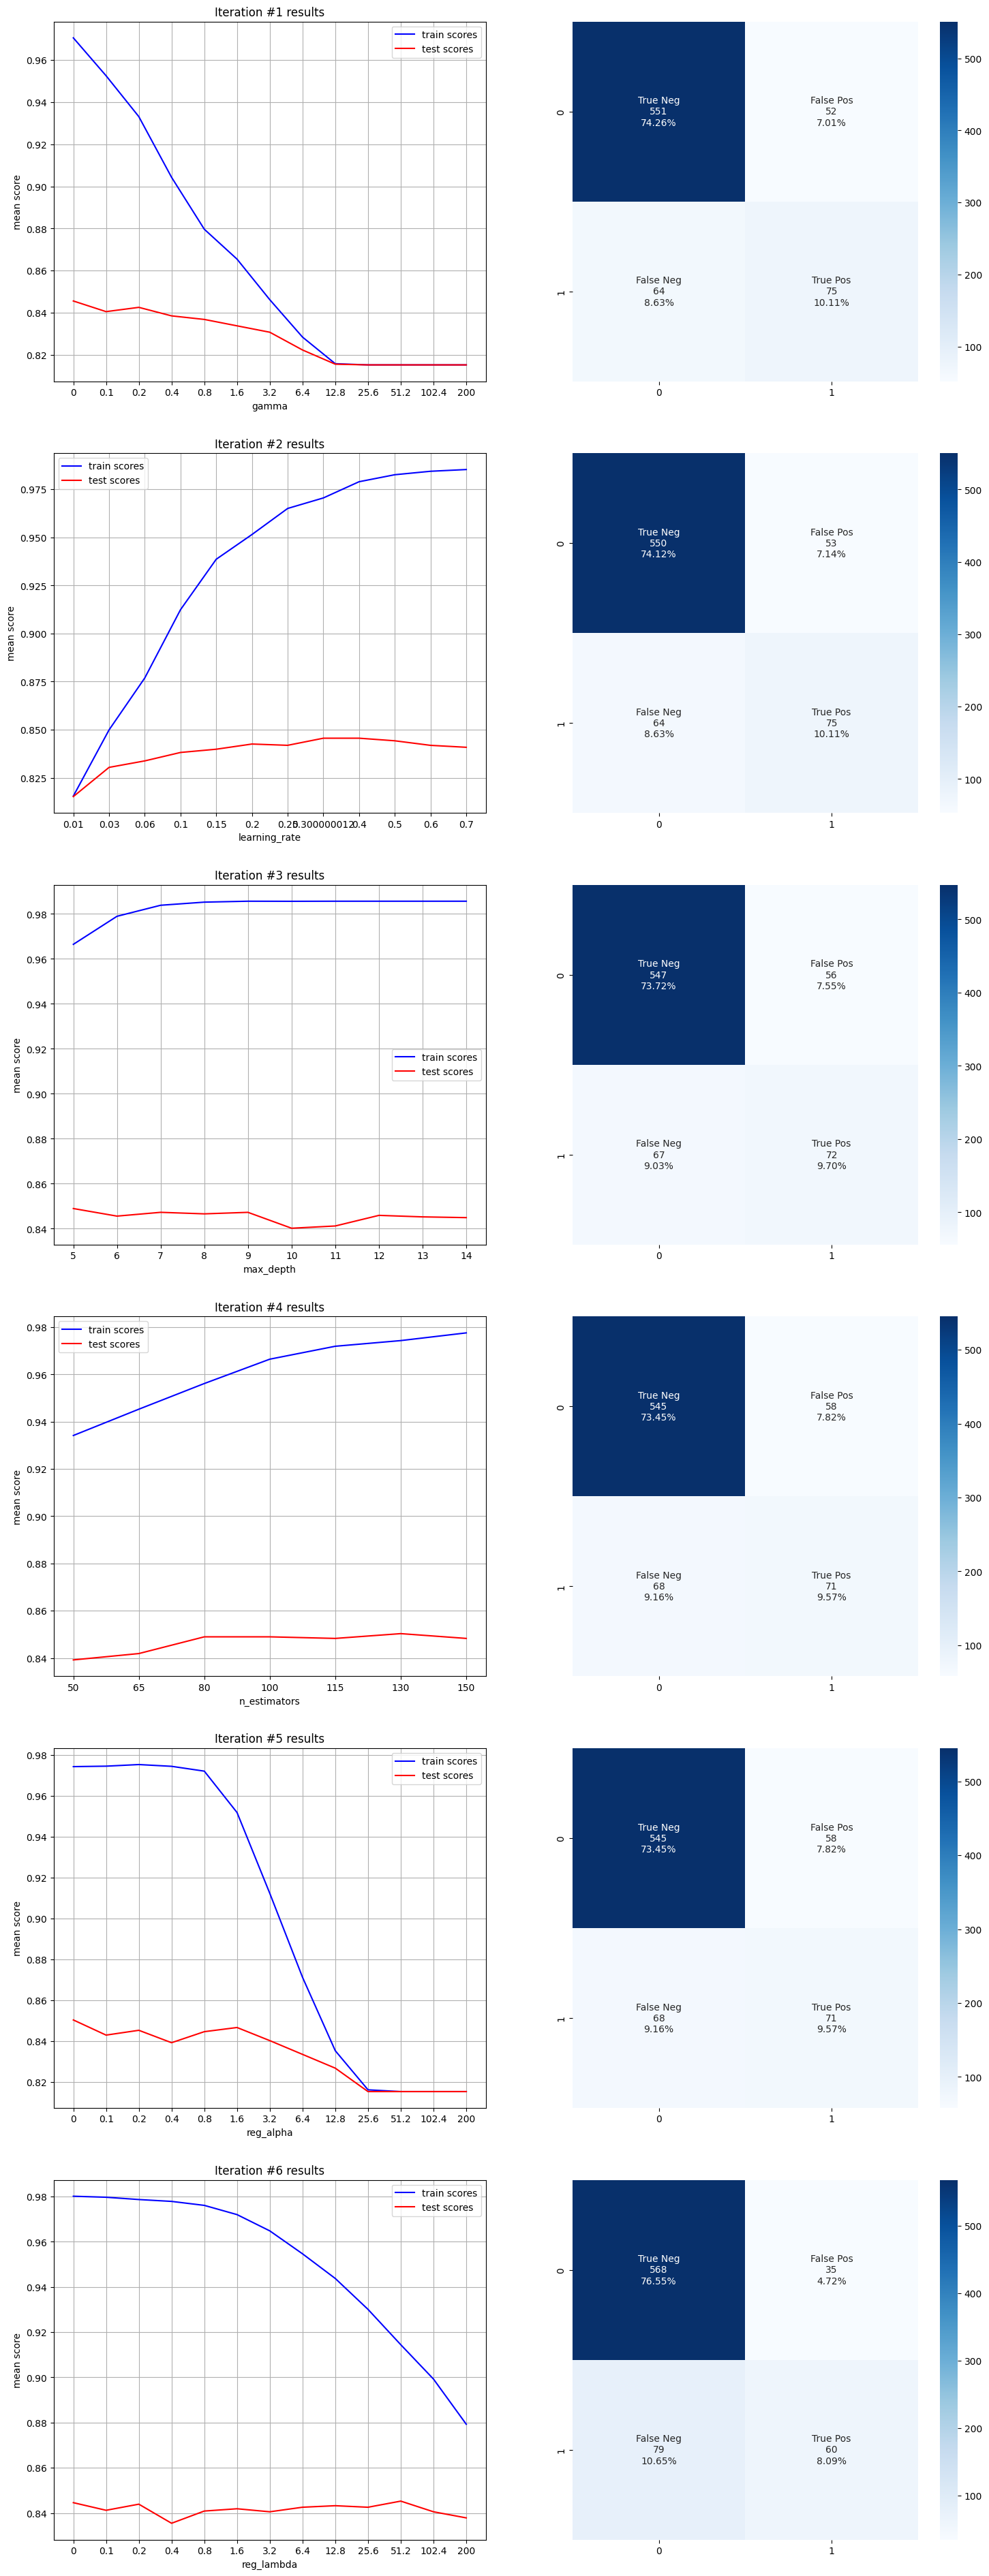

In [30]:
#plot ROC_AUC and confusion matrix for xgbc (maccs fp) model on train and test set
plots_for_model()

### Train new model on best hyperparameters

In [69]:
for i, model in enumerate(model_results):
    if model != 'xgbc0':
        print(f"{list(param_grid.keys())[i-1]}:{model_results[model]['best_params'][list(param_grid.keys())[i-1]]}")

gamma:0
learning_rate:0.4
max_depth:5
n_estimators:130
reg_alpha:0
reg_lambda:51.2


In [72]:
best_params = {'gamma':0,
              'learning_rate':0.4,
              'max_depth':5,
              'n_estimators':130,
              'reg_alpha':0,
              'reg_lambda':51.2}

In [77]:
crossvalidation('opti_clf', static_train_x, static_test_x, static_train_y, 
    static_test_y, best_params, params, iterable_parameter=np.nan)

Fitting 10 folds for each of 13 candidates, totalling 130 fits
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.229295      0.028933         0.003540        0.000425   
1        0.227071      0.076516         0.004918        0.004799   
2        0.230743      0.057781         0.004560        0.002541   
3        0.196225      0.040188         0.005165        0.003903   
4        0.249351      0.068211         0.005439        0.004190   
5        0.190948      0.035592         0.003458        0.000552   
6        0.211910      0.062940         0.004030        0.001337   
7        0.183880      0.009739         0.003246        0.000065   
8        0.197192      0.031405         0.003752        0.001412   
9        0.209412      0.039079         0.003945        0.001977   
10       0.193843      0.027867         0.003206        0.000060   
11       0.186145      0.032052         0.004947        0.003491   
12       0.212293      0.052360         0.003316     

### AUC_ROC curve

In [ ]:
# model name
file_name = "xgb_best_params.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))